In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import glob
import os

In [2]:
keras = tf.keras
layers = tf.keras.layers

## 数据读取部分

#### 训练集

In [3]:
# 指定训练和验证数据集的路径
train_image_path = glob.glob('./train/*/*.jpg')

In [4]:
train_image_path[:5]

['./train\\0\\exp1_num_108719.jpg',
 './train\\0\\exp1_num_108889.jpg',
 './train\\0\\exp1_num_265077.jpg',
 './train\\0\\exp1_num_290998.jpg',
 './train\\0\\exp1_num_297464.jpg']

In [5]:
train_image_path[0].split('\\')[1][0]

'0'

In [6]:
train_image_label = [int(p.split('\\')[1][0])  for p in train_image_path ]

In [7]:
train_image_label[240:250]

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]

In [8]:
# 训练集图片读取
def load_train_image(path,label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image,channels=1)    # 解码图片
    image = tf.image.grayscale_to_rgb(image)
    image = tf.image.resize(image,[256,256])
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image,0.1)
    image = tf.cast(image,tf.float32)   
    image = image/255                                 # 先转换成float类型，再进行归一化处理
    label = tf.reshape(label,[1])                     # [0,0,1]——>[[0],[0],[1]]
    return image,label

# 测试集图片读取
def load_test_image(path,label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image,channels=1)    # 解码图片
    image = tf.image.grayscale_to_rgb(image)
    image = tf.image.resize(image,[256,256])
    image = tf.cast(image,tf.float32)   
    image = image/255                                 # 先转换成float类型，再进行归一化处理
    label = tf.reshape(label,[1])                     # [0,0,1]——>[[0],[0],[1]]
    return image,label

In [9]:
train_image_ds = tf.data.Dataset.from_tensor_slices((train_image_path,train_image_label))
AUTOTUNE = tf.data.experimental.AUTOTUNE  # 根据CPU性能进行自动分配并行运算
train_image_ds = train_image_ds.map(load_train_image,num_parallel_calls=AUTOTUNE)

In [10]:
BATCH_SIZE = 8
train_count = len(train_image_path)

In [11]:
train_image_ds = train_image_ds.repeat().shuffle(200).batch(BATCH_SIZE)
train_image_ds = train_image_ds.prefetch(AUTOTUNE)  #训练的时候预读取一部分数据，这样可以加快速度

#### 测试集

In [12]:
test_image_path = glob.glob('./test/*/*.jpg')

In [13]:
test_count = len(test_image_path)

In [14]:
test_count

48

In [15]:
test_image_label = [int(p.split('\\')[1][0])  for p in test_image_path ]

In [16]:
test_image_label[-5:]

[3, 3, 3, 3, 3]

In [17]:
test_image_ds = tf.data.Dataset.from_tensor_slices((test_image_path,test_image_label))

In [18]:
test_image_ds = test_image_ds.map(load_test_image,num_parallel_calls=AUTOTUNE)
test_image_ds = test_image_ds.repeat().batch(BATCH_SIZE)
test_image_ds = test_image_ds.prefetch(AUTOTUNE)  #训练的时候预读取一部分数据，这样可以加快速度

#### 模型model

In [19]:
# 加载ResNet50预训练模型，不包含顶层
covn_base = tf.keras.applications.ResNet101V2(weights='imagenet', include_top=False, input_shape=(256,256,3))
# 设置参数不可训练
covn_base.trainable = False
model = keras.Sequential()
model.add(covn_base)  # 卷积基
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(512,activation='relu'))   
model.add(tf.keras.layers.Dropout(0.5))
model.add(layers.Dense(256,activation='relu'))
model.add(keras.layers.BatchNormalization())    # 批标准化      
model.add(tf.keras.layers.Dropout(0.5))
model.add(layers.Dense(64,activation='relu'))
model.add(keras.layers.BatchNormalization())    # 批标准化      
model.add(tf.keras.layers.Dropout(0.5))
model.add(layers.Dense(64,activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(layers.Dense(4,activation='softmax'))

In [20]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),
             loss='sparse_categorical_crossentropy', 
             metrics=['acc']
             )

In [21]:
epochs = 180
history = model.fit(
    train_image_ds,
    steps_per_epoch=train_count//BATCH_SIZE,
    epochs=epochs,
    validation_data=test_image_ds,
    validation_steps=len(test_image_path)//BATCH_SIZE
)

Epoch 1/180
33/33 [==============================] - 14s 124ms/step - loss: 1.9912 - acc: 0.2273 - val_loss: 1.5028 - val_acc: 0.1875
Epoch 2/180
33/33 [==============================] - 2s 74ms/step - loss: 1.7964 - acc: 0.2841 - val_loss: 1.3901 - val_acc: 0.3125
Epoch 3/180
33/33 [==============================] - 3s 78ms/step - loss: 1.6301 - acc: 0.3258 - val_loss: 1.2876 - val_acc: 0.4583
Epoch 4/180
33/33 [==============================] - 2s 75ms/step - loss: 1.6501 - acc: 0.2879 - val_loss: 1.2350 - val_acc: 0.4792
Epoch 5/180
33/33 [==============================] - 3s 79ms/step - loss: 1.6393 - acc: 0.2879 - val_loss: 1.2175 - val_acc: 0.4583
Epoch 6/180
33/33 [==============================] - 2s 70ms/step - loss: 1.4955 - acc: 0.3409 - val_loss: 1.1964 - val_acc: 0.4583
Epoch 7/180
33/33 [==============================] - 2s 69ms/step - loss: 1.6049 - acc: 0.3106 - val_loss: 1.2234 - val_acc: 0.4583
Epoch 8/180
33/33 [==============================] - 2s 73ms/step - loss: 

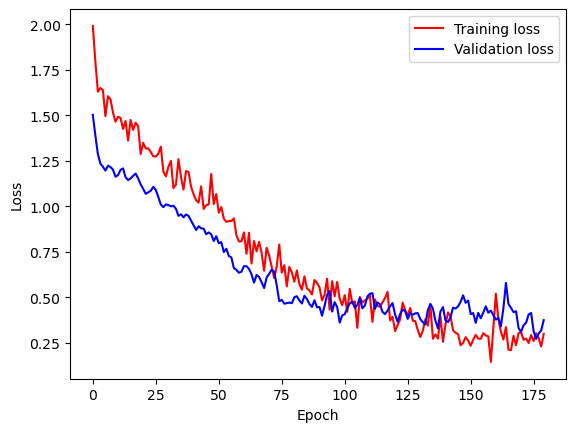

In [22]:
plt.plot(history.history['loss'], 'r', label='Training loss')
plt.plot(history.history['val_loss'], 'b', label='Validation loss')
plt.xlabel('Epoch')  # x轴变量名称  
plt.ylabel('Loss')  # y轴变量名称  
plt.legend()  # 画出曲线图标  

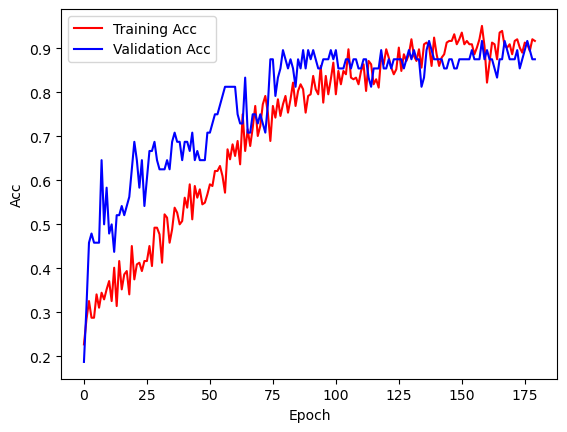

In [23]:
plt.plot(history.history['acc'], 'r', label='Training Acc')
plt.plot(history.history['val_acc'], 'b', label='Validation Acc')
plt.xlabel('Epoch')  # x轴变量名称  
plt.ylabel('Acc')  # y轴变量名称  
plt.legend()  # 画出曲线图标  

In [24]:
covn_base.trainable = True

# fine_tune_at = -10

# for layer in covn_base.layers[:fine_tune_at]:
#     layers.trainable = False

# 一定要以更低的学习速率
model.compile( loss='sparse_categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005/10),
              metrics=['acc']
             )
initial_epochs = 180       #已经训练的epoch
fine_tune_epochs = 250    #继续训练的epoch
total_epochs = initial_epochs + fine_tune_epochs

In [25]:
history = model.fit(
    train_image_ds,
    steps_per_epoch = train_count//BATCH_SIZE,
    epochs=total_epochs,
    initial_epoch=initial_epochs,
    validation_data=test_image_ds,
    validation_steps=test_count//BATCH_SIZE
)

Epoch 181/430
33/33 [==============================] - 19s 221ms/step - loss: 2.4896 - acc: 0.3902 - val_loss: 0.6630 - val_acc: 0.8333
Epoch 182/430
33/33 [==============================] - 6s 178ms/step - loss: 2.2254 - acc: 0.4318 - val_loss: 1.1456 - val_acc: 0.7500
Epoch 183/430
33/33 [==============================] - 6s 178ms/step - loss: 2.1787 - acc: 0.4280 - val_loss: 1.1505 - val_acc: 0.7500
Epoch 184/430
33/33 [==============================] - 6s 181ms/step - loss: 1.7486 - acc: 0.4924 - val_loss: 1.4335 - val_acc: 0.6875
Epoch 185/430
33/33 [==============================] - 6s 177ms/step - loss: 1.7219 - acc: 0.4924 - val_loss: 1.7350 - val_acc: 0.5417
Epoch 186/430
33/33 [==============================] - 6s 176ms/step - loss: 1.7503 - acc: 0.4848 - val_loss: 1.6204 - val_acc: 0.5833
Epoch 187/430
33/33 [==============================] - 6s 178ms/step - loss: 1.6677 - acc: 0.5341 - val_loss: 1.6090 - val_acc: 0.5417
Epoch 188/430
33/33 [==============================] -

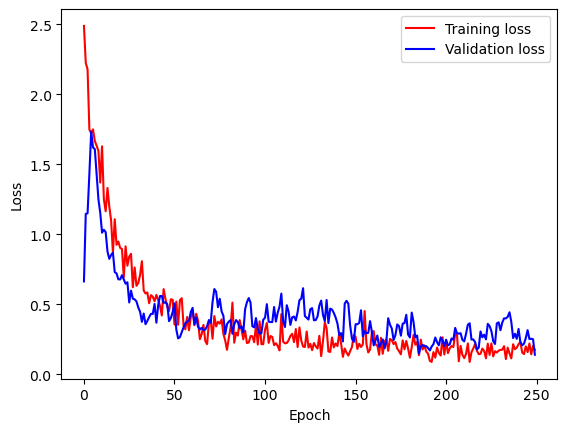

In [26]:
plt.plot(history.history['loss'], 'r', label='Training loss')
plt.plot(history.history['val_loss'], 'b', label='Validation loss')
plt.xlabel('Epoch')  # x轴变量名称  
plt.ylabel('Loss')  # y轴变量名称  
plt.legend()  # 画出曲线图标  

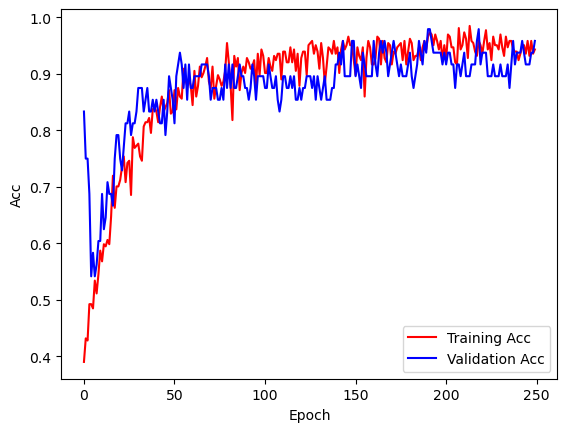

In [27]:
plt.plot(history.history['acc'], 'r', label='Training Acc')
plt.plot(history.history['val_acc'], 'b', label='Validation Acc')
plt.xlabel('Epoch')  # x轴变量名称  
plt.ylabel('Acc')  # y轴变量名称  
plt.legend()  # 画出曲线图标  

In [ ]:
model.save('model_surface_defect1024.h5')

In [ ]:
new_model = tf.keras.models.load_model('model_surface_defect1024.h5')

In [ ]:
# 测试集图片读取
def load_predict_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image,channels=1)    # 解码图片
    image = tf.image.grayscale_to_rgb(image)
    image = tf.cast(image,tf.float32)   
    image = image/255                                 # 先转换成float类型，再进行归一化处理       
    return image

In [ ]:
img_path = r'C:\Users\Administrator\Desktop\Workers\chenceng\gray_train\2liugua\12_2_8_12.jpg'
img = load_predict_image(img_path)

In [ ]:
img.shape

In [ ]:
img = tf.expand_dims(img, axis=0)

pred = new_model.predict(img)

In [ ]:
pred 

In [ ]:
label_to_index = {'无缺陷': 0,'漏涂': 1,'流挂': 2,'堆积': 3}

index_to_label = dict((v, k) for k, v in label_to_index.items())



In [ ]:
np.argmax(pred)

In [ ]:
index_to_label.get(np.argmax(pred))